# IDE Usage Analysis (March–May 2025)
**Author:** Paweł Dorosz   
**Country of Residence:** Poland 
**Date:** 11.2025  
**Environment:** Python 3.13.5, Jupyter Notebook  

---

## Environment & Dependencies

**Python version:** 3.10+  
**Recommended IDE:** Jupyter Notebook / Google Colab / JetBrains Datalore  

---

### Overview
This notebook explores user activity data collected over a three-month period (March–May 2025).  
The dataset contains anonymized daily aggregates describing how users interact with different large language models, features, and license types inside an IDE.

---


We aim to:
- Understand user behavior and spending patterns  
- Compare models, licenses, and features  
- Identify trends and correlations  
- Provide actionable recommendations for product and pricing decisions


## 0. Importing libraries

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns  


# Display options
pd.set_option("display.max_columns", None)

## 1. Load and Inspect Data

In this step we:
- Load the CSV file
- Parse date columns
- Display a quick preview to ensure the dataset looks correct

In [177]:
data_path = "da_internship_task_dataset.csv"
df = pd.read_csv(data_path, parse_dates=["day_id"])

# Basic info
df.info()
display(df.head())
print("\nMissing values per column:\n", df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122746 entries, 0 to 122745
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   uuid          122746 non-null  object        
 1   day_id        122746 non-null  datetime64[ns]
 2   license       122746 non-null  object        
 3   model         122746 non-null  object        
 4   feature       122746 non-null  object        
 5   requests_cnt  122746 non-null  float64       
 6   spent_amount  122746 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 6.6+ MB


,uuid,day_id,license,model,feature,requests_cnt,spent_amount
0,user_920,2025-05-01,Premium,Model_A,Feature_1,44.0,16.38
1,user_717,2025-03-04,Premium,Model_B,Feature_2,72.0,27.92
2,user_610,2025-05-08,Premium,Model_A,Feature_2,27.0,9.87
3,user_94,2025-03-11,Basic,Model_D,Feature_1,76.0,14.67
4,user_920,2025-05-14,Premium,Model_E,Feature_3,47.0,9.88



Missing values per column:
 uuid            0
day_id          0
license         0
model           0
feature         0
requests_cnt    0
spent_amount    0
dtype: int64


####  DATA QUALITY:
- 122,746 records, 0 missing values
- Clean data types and structure
- March-May 2025 timeframe confirmed

## 2. Describe


In [178]:
df.describe()


,day_id,requests_cnt,spent_amount
count,122746,122746.000000,122746.000000
mean,2025-04-18 07:01:09.040131840,51.260742,12.227798
min,2025-03-01 00:00:00,1.000000,0.270000
25%,2025-03-26 00:00:00,18.000000,5.140000
50%,2025-04-21 00:00:00,32.000000,8.020000
75%,2025-05-12 00:00:00,54.000000,13.060000
max,2025-05-31 00:00:00,12900.000000,2599.000000
std,NaN,167.977380,37.588494


#### KEY INSIGHTS:
- **High Variance**: Significant spread in usage (1 to 12,900 requests/day)
- **Skewed Distribution**: Mean (51) > Median (32) indicates heavy users
- **Spending Range**: 0.27 to 2,599 daily per user
- **Potential Outliers**: Max values suggest extreme usage cases

#### NOTES:
Extreme values may require outlier treatment for robust analysis.

## 3. Data Cleaning & Preparation

In this step, we ensure that the dataset is clean, consistent, and ready for analysis.  
We will:

- Convert numeric columns to appropriate data types  
- Check for duplicates and negative values  
- Explore data distributions to detect potential outliers  
- Perform Z-score–based outlier detection and sensitivity analysis  
- Decide whether to remove outliers  
- Add time-based helper columns (`month`, `week`, `weekday`) for aggregation  
- Verify final dataset statistics

Duplicate rows (same user/day/model/feature/license): 0
Negative requests: 0, Negative spent_amount: 0

=== DATA DISTRIBUTION ANALYSIS ===


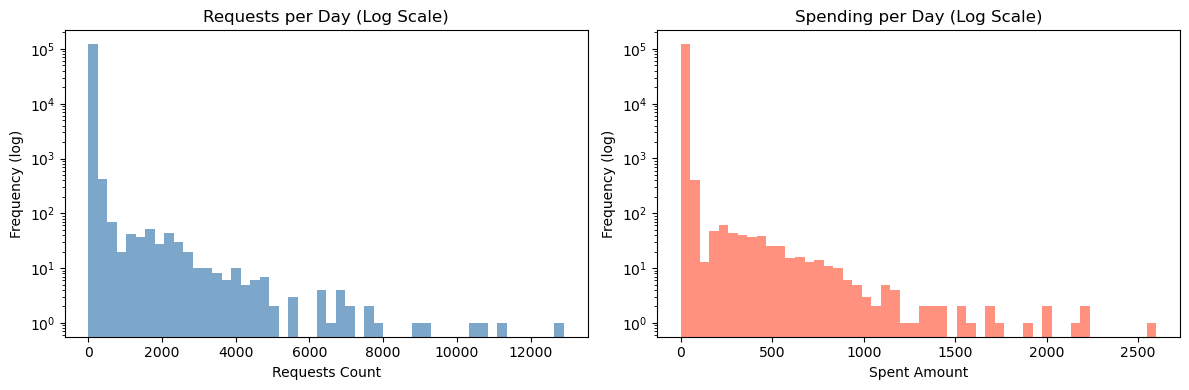


=== Z-SCORE OUTLIER DETECTION ===
Outliers (>3 STD): 449 (0.37% of data)

=== SENSITIVITY ANALYSIS ===
Total requests: +15.20%
Total spending: +14.98%
Avg requests/day: +14.89%
Avg spending/day: +14.67%

Outliers significantly affect distribution and the market share (by model) — use cleaned dataset

=== FINAL DATASET STATUS ===
Rows: 122297
Date range: 2025-03-01 00:00:00 → 2025-05-31 00:00:00
Total requests: 5,335,801
Total spent: 1,276,049.28


In [179]:
# We don't have to drop missing values because in previous step we saw that there is no missing values in the dataset.

# === DATA CLEANING & PREPARATION ===

#  Convert numeric columns
df['requests_cnt'] = pd.to_numeric(df['requests_cnt'], errors='raise').astype(int)
df['spent_amount'] = pd.to_numeric(df['spent_amount'], errors='raise')

#  Check for duplicates and negative values
duplicates = df.duplicated(subset=['uuid', 'day_id', 'model', 'feature', 'license']).sum()
neg_requests = (df['requests_cnt'] < 0).sum()
neg_spent = (df['spent_amount'] < 0).sum()

print(f"Duplicate rows (same user/day/model/feature/license): {duplicates}")
print(f"Negative requests: {neg_requests}, Negative spent_amount: {neg_spent}")

#  Visual inspection of data distribution (log-scale histograms)
print("\n=== DATA DISTRIBUTION ANALYSIS ===")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['requests_cnt'], bins=50, color='steelblue', alpha=0.7, log=True)
axes[0].set_title('Requests per Day (Log Scale)')
axes[0].set_xlabel('Requests Count')
axes[0].set_ylabel('Frequency (log)')

axes[1].hist(df['spent_amount'], bins=50, color='tomato', alpha=0.7, log=True)
axes[1].set_title('Spending per Day (Log Scale)')
axes[1].set_xlabel('Spent Amount')
axes[1].set_ylabel('Frequency (log)')

plt.tight_layout()
plt.show()

#  Outlier detection using Z-score
print("\n=== Z-SCORE OUTLIER DETECTION ===")
z_requests = np.abs(stats.zscore(df['requests_cnt']))
z_spent = np.abs(stats.zscore(df['spent_amount']))

outliers = (z_requests > 3) | (z_spent > 3)
print(f"Outliers (>3 STD): {outliers.sum()} ({outliers.sum() / len(df) * 100:.2f}% of data)")

#  Sensitivity analysis — check effect of removing outliers
df_clean = df[~outliers]

def diff_percent(original, clean, metric, label):
    diff = ((original - clean) / original) * 100
    print(f"{label}: {diff:+.2f}%")

print("\n=== SENSITIVITY ANALYSIS ===")
diff_percent(df['requests_cnt'].sum(), df_clean['requests_cnt'].sum(), 'requests', 'Total requests')
diff_percent(df['spent_amount'].sum(), df_clean['spent_amount'].sum(), 'spent', 'Total spending')
diff_percent(df['requests_cnt'].mean(), df_clean['requests_cnt'].mean(), 'requests', 'Avg requests/day')
diff_percent(df['spent_amount'].mean(), df_clean['spent_amount'].mean(), 'spent', 'Avg spending/day')

# Market share comparison before/after cleaning
original_share = df.groupby('model')['requests_cnt'].sum() / df['requests_cnt'].sum()
clean_share = df_clean.groupby('model')['requests_cnt'].sum() / df_clean['requests_cnt'].sum()
share_diff = (clean_share - original_share) * 100

if abs(share_diff).max() < 1:
    print("\nOutliers have minimal impact (<1% change) — keep full dataset")
else:
    print("\nOutliers significantly affect distribution and the market share (by model) — use cleaned dataset")
    df = df_clean

#  Add helper time-based columns
df['month'] = df['day_id'].dt.to_period('M').astype(str)
df['week'] = df['day_id'].dt.isocalendar().week.astype(int)
df['weekday'] = df['day_id'].dt.day_name()

# Final sanity checks
print("\n=== FINAL DATASET STATUS ===")
print("Rows:", df.shape[0])
print("Date range:", df['day_id'].min(), "→", df['day_id'].max())
print(f"Total requests: {df['requests_cnt'].sum():,}")
print(f"Total spent: {df['spent_amount'].sum():,.2f}")


## 4. Exploratory Analysis

In this step, we aim to understand the dataset structure and behavioral patterns from multiple angles — temporal, model-based, feature-based, and license-based.

Specifically, we will:

- Compute general activity metrics (requests, spend, users)

- Explore daily / weekly / monthly engagement

- Compare models, licenses, and features

- Visualize relationships between usage and spending

- Identify top-performing combinations

In [180]:
# === 4.1 GENERAL STATISTICS ===

print("=== OVERALL DATASET METRICS ===")

total_requests = df['requests_cnt'].sum()
total_spent = df['spent_amount'].sum()
total_users = df['uuid'].nunique()

print(f"• Total requests: {total_requests:,}")
print(f"• Total spent: {total_spent:,.2f}")
print(f"• Unique users: {total_users:,}")
print(f"• Average requests per user: {total_requests / total_users:.2f}")
print(f"• Average spending per user: {total_spent / total_users:.2f}")

# Summary stats
display(df[['requests_cnt', 'spent_amount']].describe())


=== OVERALL DATASET METRICS ===
• Total requests: 5,335,801
• Total spent: 1,276,049.28
• Unique users: 1,851
• Average requests per user: 2882.66
• Average spending per user: 689.38


,requests_cnt,spent_amount
count,122297.000000,122297.000000
mean,43.629860,10.434019
std,39.860844,8.061744
min,1.000000,0.270000
25%,18.000000,5.140000
50%,32.000000,7.990000
75%,54.000000,12.990000
max,540.000000,124.000000


#### General Business Metrics

Platform Performance:
- 5.3M total requests over 3 months
- 1.28M total spent_amount
- 1,851 unique users engaged
- High user value: 689 credits average spending per user

📅 ACTIVITY SUMMARY:


• Min DAU: 166 | Avg DAU: 713 | Max DAU: 1030
• Min WAU: 331 | Avg WAU: 1410 | Max WAU: 1685
• Min MAU: 1455 | Avg MAU: 1641 | Max MAU: 1847


,requests_cnt,spent_amount,unique_users
month,,,
2025-03,1668402,403473.18,1455
2025-04,1647661,393172.81,1620
2025-05,2019738,479403.29,1847


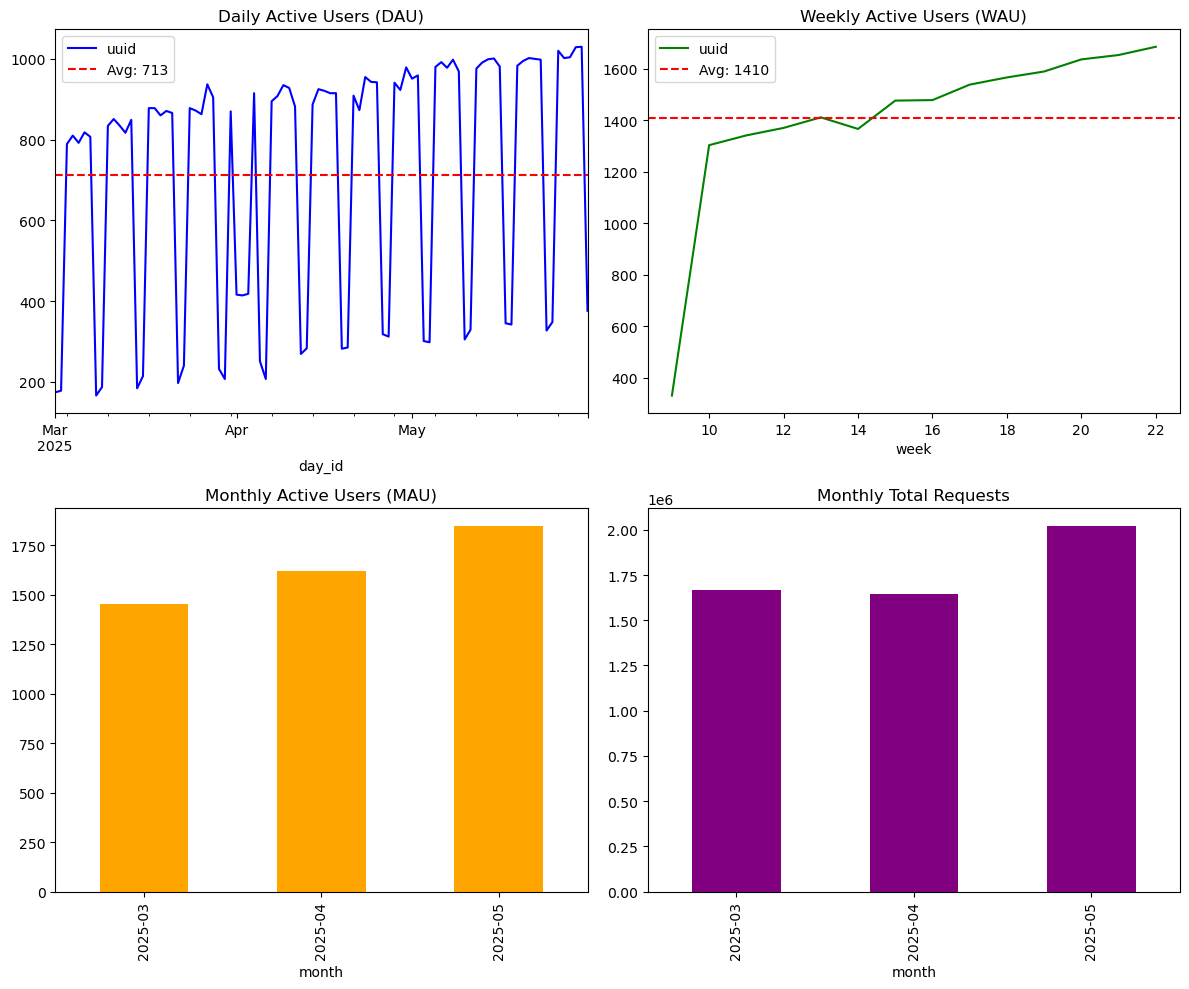

In [181]:
# === 4.2 TEMPORAL ACTIVITY TRENDS ===

# Compute DAU, WAU, MAU
dau = df.groupby('day_id')['uuid'].nunique()
wau = df.groupby('week')['uuid'].nunique()
mau = df.groupby('month')['uuid'].nunique()

print("📅 ACTIVITY SUMMARY:")
print(f"• Min DAU: {dau.min():.0f} | Avg DAU: {dau.mean():.0f} | Max DAU: {dau.max():.0f}")
print(f"• Min WAU: {wau.min():.0f} | Avg WAU: {wau.mean():.0f} | Max WAU: {wau.max():.0f}")
print(f"• Min MAU: {mau.min():.0f} | Avg MAU: {mau.mean():.0f} | Max MAU: {mau.max():.0f}")

# Monthly summary
monthly_summary = df.groupby('month').agg({
    'requests_cnt': 'sum',
    'spent_amount': 'sum',
    'uuid': 'nunique'
}).rename(columns={'uuid': 'unique_users'})

display(monthly_summary)

# Visualization — DAU / WAU / MAU and monthly activity
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

dau.plot(ax=axes[0,0], title='Daily Active Users (DAU)', color='blue')
axes[0,0].axhline(y=dau.mean(), color='red', linestyle='--', label=f'Avg: {dau.mean():.0f}')
axes[0,0].legend()

wau.plot(ax=axes[0,1], title='Weekly Active Users (WAU)', color='green')
axes[0,1].axhline(y=wau.mean(), color='red', linestyle='--', label=f'Avg: {wau.mean():.0f}')
axes[0,1].legend()

monthly_summary['unique_users'].plot.bar(ax=axes[1,0], title='Monthly Active Users (MAU)', color='orange')
monthly_summary['requests_cnt'].plot.bar(ax=axes[1,1], title='Monthly Total Requests', color='purple')

plt.tight_layout()
plt.show()


#### Temporal Activity Trends

User Engagement:
- Strong growth: MAU increased from 1,455 to 1,847 (+27% growth)
- Consistent engagement: Avg 713 daily active users
- Healthy retention: Avg 1,410 weekly active users

Monthly Performance:
- May shows highest activity: 2.0M requests, 479K spending
- Steady platform growth across all metrics
- Increasing user base driving request volume

,requests_cnt,spent_amount,unique_users,avg_spent_per_user,avg_requests_per_user
license,,,,,
Basic,956323,228119.28,711,320.842869,1345.039381
Enterprise,1804874,429014.90,251,1709.222709,7190.733068
Premium,1333278,317919.11,245,1297.629020,5441.951020
Standard,1241326,300995.99,701,429.380870,1770.793153


Top license by requests: Enterprise
Top license by spending: Enterprise


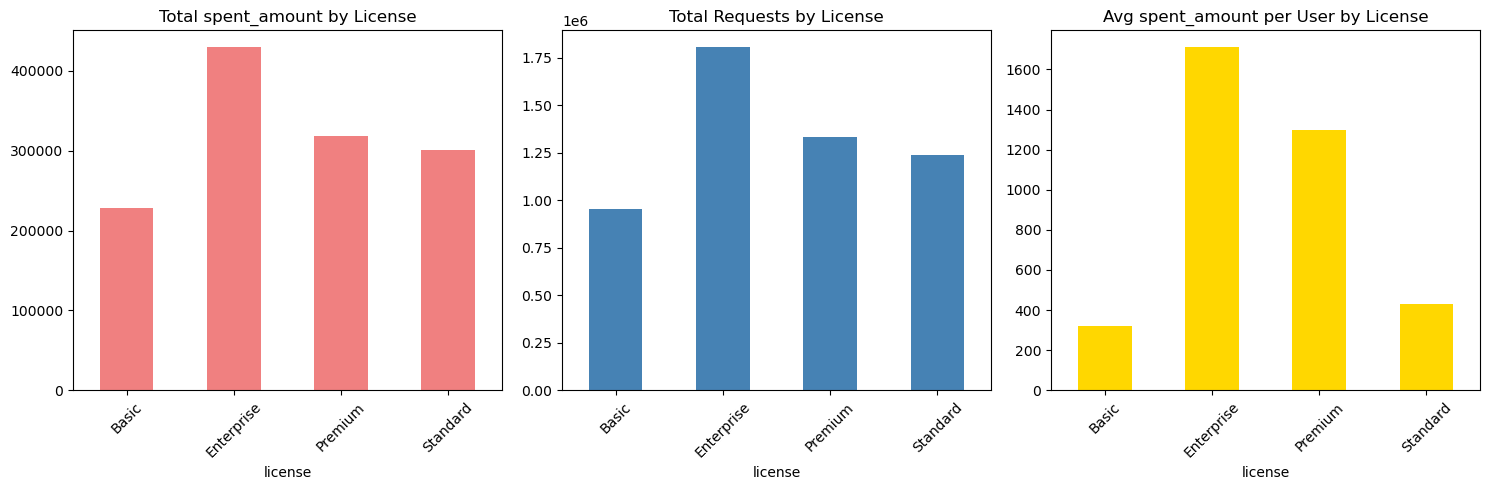

In [182]:
# === 4.3 LICENSE-LEVEL ANALYSIS ===

license_stats = df.groupby('license').agg({
    'requests_cnt': 'sum',
    'spent_amount': 'sum',
    'uuid': 'nunique'
}).rename(columns={'uuid': 'unique_users'})

license_stats['avg_spent_per_user'] = license_stats['spent_amount'] / license_stats['unique_users']
license_stats['avg_requests_per_user'] = license_stats['requests_cnt'] / license_stats['unique_users']

display(license_stats)

print(f"Top license by requests: {license_stats['requests_cnt'].idxmax()}")
print(f"Top license by spending: {license_stats['spent_amount'].idxmax()}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

license_stats['spent_amount'].plot.bar(ax=axes[0], title='Total spent_amount by License', color='lightcoral')
license_stats['requests_cnt'].plot.bar(ax=axes[1], title='Total Requests by License', color='steelblue')
license_stats['avg_spent_per_user'].plot.bar(ax=axes[2], title='Avg spent_amount per User by License', color='gold')

for ax in axes: ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


#### License Performance Analysis

Revenue Drivers:
- Enterprise leads: Highest spending (1,709 per user) and requests (7,191 per user)
- Premium strong: Second highest engagement with 1,298 per user spending
- Basic efficient: Largest user base (711) with moderate 321 per user value

,requests_cnt,spent_amount,cost_per_request,market_share
model,,,,
Model_D,1644000,315761.48,0.192069,30.810744
Model_C,1508946,285515.89,0.189215,28.279653
Model_A,854633,314889.64,0.368450,16.016958
Model_E,720801,136983.83,0.190044,13.508768
Model_B,607421,222898.44,0.366959,11.383877


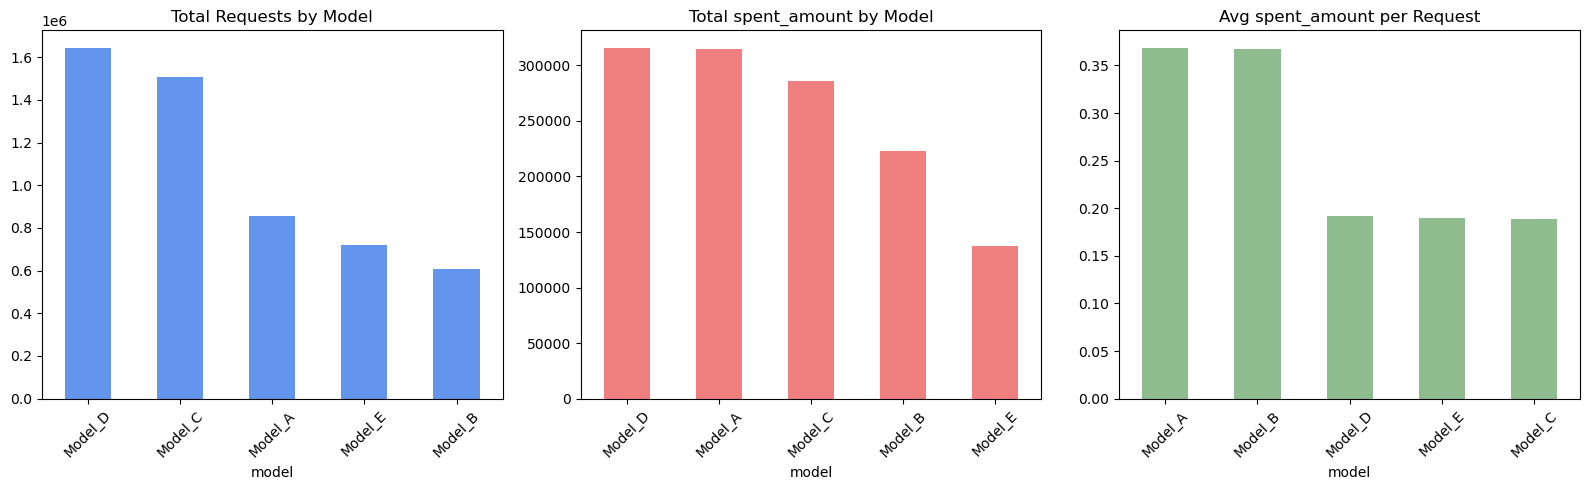

In [183]:
# === 4.4 MODEL PERFORMANCE ===

model_stats = df.groupby('model').agg({
    'requests_cnt': 'sum',
    'spent_amount': 'sum'
})
model_stats['cost_per_request'] = model_stats['spent_amount'] / model_stats['requests_cnt']
model_stats['market_share'] = model_stats['requests_cnt'] / model_stats['requests_cnt'].sum() * 100

display(model_stats.sort_values('requests_cnt', ascending=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

model_stats['requests_cnt'].sort_values(ascending=False).plot.bar(ax=axes[0], title='Total Requests by Model', color='cornflowerblue')
model_stats['spent_amount'].sort_values(ascending=False).plot.bar(ax=axes[1], title='Total spent_amount by Model', color='lightcoral')
model_stats['cost_per_request'].sort_values(ascending=False).plot.bar(ax=axes[2], title='Avg spent_amount per Request', color='darkseagreen')

for ax in axes: ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

#### Model Performance Analysis

Market Leadership:
- Model_D leads: 30.8% market share, highest usage (1.64M requests)
- Model_C strong contender: 28.3% share with excellent cost efficiency ($0.19/request)
- Model_A costly: Only 16.0% share but highest cost per request ($0.37)

Strategic Insight:
Model_D and Model_C dominate with optimal cost-performance balance, while Model_A faces pricing challenges despite solid usage.
Model_A and Model_B are almost two times more expensive the other

,requests_cnt,spent_amount,cost_per_request
feature,,,
Feature_1,2293979,528453.66,0.230366
Feature_2,1489475,364234.51,0.244539
Feature_3,958529,246432.01,0.257094
Feature_4,334005,76129.63,0.227930
Feature_5,259813,60799.47,0.234012


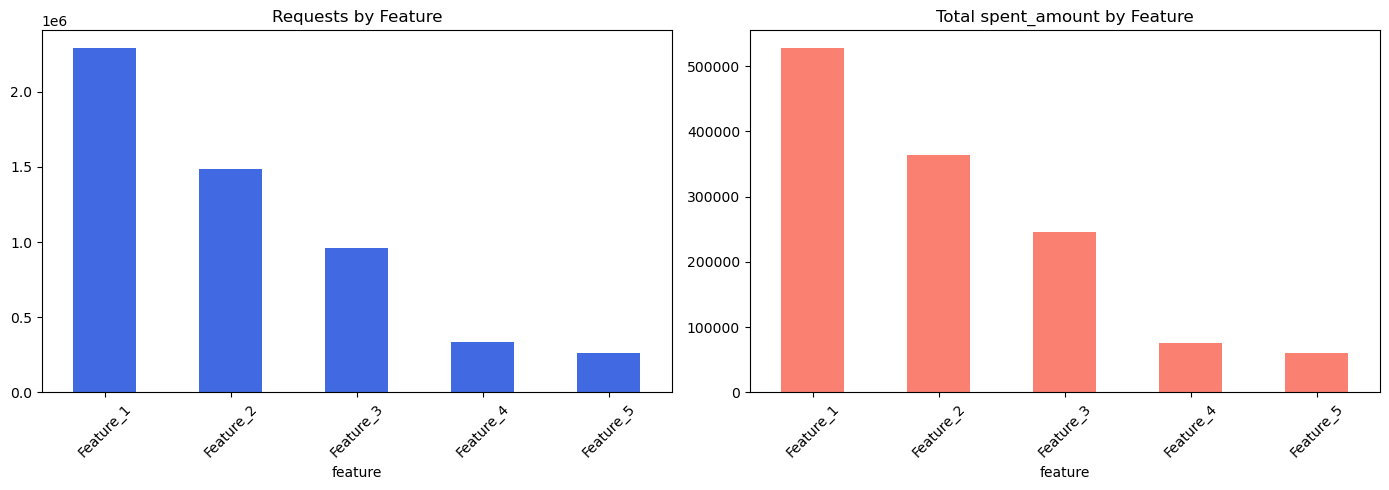

In [184]:
# === 4.5 FEATURE USAGE ===

feature_stats = df.groupby('feature').agg({
    'requests_cnt': 'sum',
    'spent_amount': 'sum'
})
feature_stats['cost_per_request'] = feature_stats['spent_amount'] / feature_stats['requests_cnt']

display(feature_stats.sort_values('requests_cnt', ascending=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
feature_stats['requests_cnt'].plot.bar(ax=axes[0], title='Requests by Feature', color='royalblue')
feature_stats['spent_amount'].plot.bar(ax=axes[1], title='Total spent_amount by Feature', color='salmon')
for ax in axes: ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


#### Feature Usage Analysis

Cost Efficiency:
- Comparable pricing: All features maintain similar spent_amount per request (0.23-0.26)
- Feature_1 dominance: 43.0% of total requests, driving nearly half of platform activity
- Balanced engagement: Features 2-5 show steady, distributed usage patterns

Strategic Insight:
Consistent pricing model across features with clear user preference for Feature_1's core functionality.

In [185]:
# === 4.6 CROSS-DIMENSIONAL ANALYSIS ===

# Top feature-model combinations
top_combinations = (
    df.groupby(['feature', 'model'])
      .agg({'requests_cnt': 'sum', 'spent_amount': 'sum'})
      .sort_values('requests_cnt', ascending=False)
      .head(10)
)
display(top_combinations)


requests_cnt  spent_amount
feature   model                              
Feature_1 Model_C        741403     138546.00
          Model_D        696643     135478.06
Feature_2 Model_D        533351     100683.17
Feature_1 Model_E        326291      62074.79
          Model_A        315640     114629.76
Feature_2 Model_C        310411      59093.77
Feature_3 Model_C        283394      54077.04
Feature_2 Model_A        250624      92705.86
Feature_3 Model_D        215517      41754.91
Feature_1 Model_B        214002      77725.05

#### Cross-Dimensional Analysis

Top Combinations:
- Feature_1 + Model_C: Leading pair with 741K requests
- Feature_1 + Model_D: Strong alternative with 697K requests
- Model dominance: Model_C and Model_D appear in 7 of top 10 combinations

Strategic Insight:
Feature_1 drives majority of top usage patterns, paired primarily with cost-efficient Model_C and Model_D, indicating optimal product-market fit.

## 5. User-Level Analysis

In this section, we will focus on user behavior and segmentation.
Our objectives:

- Aggregate user-level metrics

- Identify engagement segments (light / medium / power users)

- Analyze spending and activity distribution

- Estimate user-level contribution to total spent_amount

In [186]:
# === 5.1 USER-LEVEL METRICS ===

user_stats = df.groupby('uuid').agg({
    'requests_cnt': 'sum',
    'spent_amount': 'sum',
    'day_id': 'nunique'
}).rename(columns={'day_id': 'active_days'})

user_stats['avg_requests_per_day'] = user_stats['requests_cnt'] / user_stats['active_days']
user_stats['avg_spent_per_day'] = user_stats['spent_amount'] / user_stats['active_days']

display(user_stats.describe())

print(f"Total unique users analyzed: {len(user_stats):,}")
print(f"Average activity span: {user_stats['active_days'].mean():.1f} days")


,requests_cnt,spent_amount,active_days,avg_requests_per_day,avg_spent_per_day
count,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000
mean,2882.658563,689.383728,35.447866,70.369513,16.891796
std,2941.731946,614.385285,18.336667,58.896414,12.404612
min,7.000000,2.330000,1.000000,7.000000,2.330000
25%,628.000000,185.900000,17.000000,28.605217,7.912553
50%,1960.000000,512.160000,43.000000,49.250000,12.314054
75%,4086.500000,1089.685000,48.000000,89.120000,24.472176
max,14571.000000,2815.260000,74.000000,350.000000,124.000000


Total unique users analyzed: 1,851
Average activity span: 35.4 days


#### User-Level Metrics

Engagement Patterns:
- High variability: Users range from 7 to 14,571 total requests
- Strong retention: Average 35.4 active days per user
- Consistent spending: Median 512 per user, 75th percentile at 1,090

User Value:
Wide engagement spectrum with significant spending concentration in top quartile users.

In [187]:
# === 5.2 USER SEGMENTATION BY TOTAL REQUESTS ===

# Define quartiles
q1, q2 = user_stats['requests_cnt'].quantile([0.5, 0.8])
conditions = [
    (user_stats['requests_cnt'] <= q1),
    (user_stats['requests_cnt'] > q1) & (user_stats['requests_cnt'] <= q2),
    (user_stats['requests_cnt'] > q2)
]
choices = ['Light', 'medium', 'Power']
user_stats['segment'] = np.select(conditions, choices, default='Unknown')

segment_summary = user_stats.groupby('segment').agg({
    'requests_cnt': ['mean', 'sum'],
    'spent_amount': ['mean', 'sum'],
    'active_days': 'mean'
}).round(2)

display(segment_summary)


requests_cnt          spent_amount            active_days
                mean      sum         mean        sum        mean
segment                                                          
Light         735.69   681989       219.34  203328.23       23.78
Power        7773.24  2876097      1622.63  600373.40       48.51
medium       3208.87  1777715       852.61  472347.65       46.24

#### User Segmentation Analysis

Segment Performance:
- Power Users (20%): Generate 54% of revenue, 7.8K avg requests
- Moderate Users (30%): Solid engagement, 3.2K avg requests  
- Light Users (50%): Broad base, 736 avg requests

Strategic Insight:
Power users drive majority of platform value with 7x higher spending than light users.

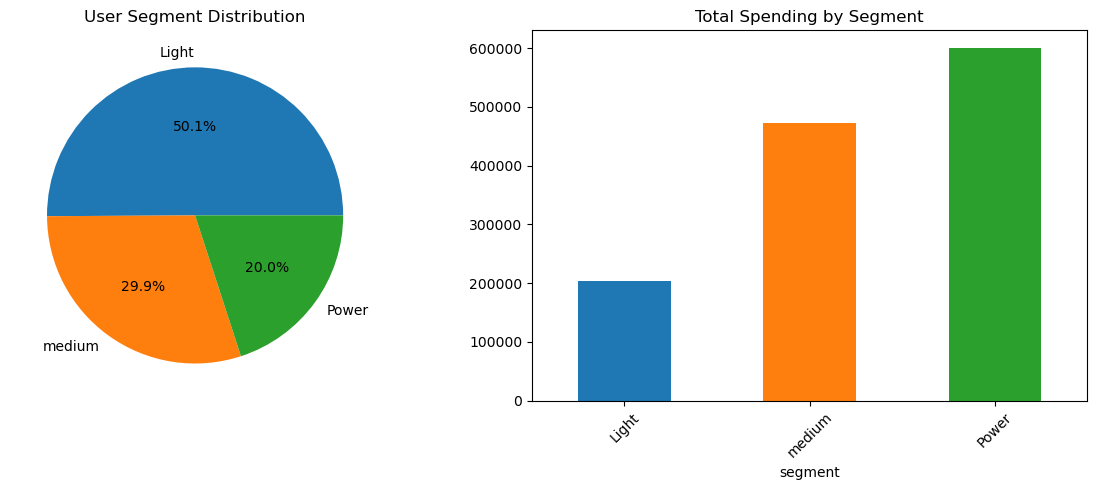

In [188]:
# === 5.3 VISUALIZING USER SEGMENTS ===
segment_spend = user_stats.groupby('segment')['spent_amount'].sum().sort_values(ascending=True)
order = segment_spend.index.tolist()

# Prepare counts for pie chart, with same order
counts = user_stats['segment'].value_counts().reindex(order).fillna(0)

import matplotlib.pyplot as plt
colors = plt.cm.tab10(range(len(order)))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

counts.plot.pie(
    autopct='%1.1f%%', ax=axes[0], title='User Segment Distribution', colors=colors
)
axes[0].set_ylabel('')

# Bar plot sorted ascending
segment_spend.plot.bar(ax=axes[1], color=colors, title='Total Spending by Segment')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Although power users account for only 20% of users, their total spending represents the highest value. (further analysis of this phenomenon below)

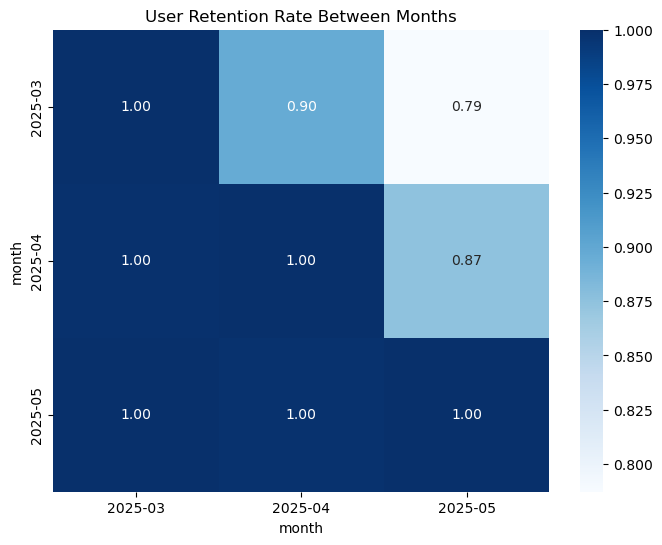

In [189]:
# === 5.4 RETENTION ANALYSIS ===

# Check which users appear in multiple months
user_months = df.groupby(['uuid', 'month']).size().unstack(fill_value=0)
retained = (user_months > 0).astype(int)

# Retention matrix
retention = retained.T.dot(retained)
retention_rate = retention / np.diag(retention)

plt.figure(figsize=(8,6))
sns.heatmap(retention_rate, annot=True, fmt=".2f", cmap="Blues")
plt.title("User Retention Rate Between Months")
plt.show()


#### Retention Analysis

Retention Performance:
- March to April: 90% of users retained
- April to May: 87% retention rate improvement  
- March to May: 79% long-term retention

Strategic Insight:
Strong monthly retention, indicating good product stickiness and user satisfaction over time.

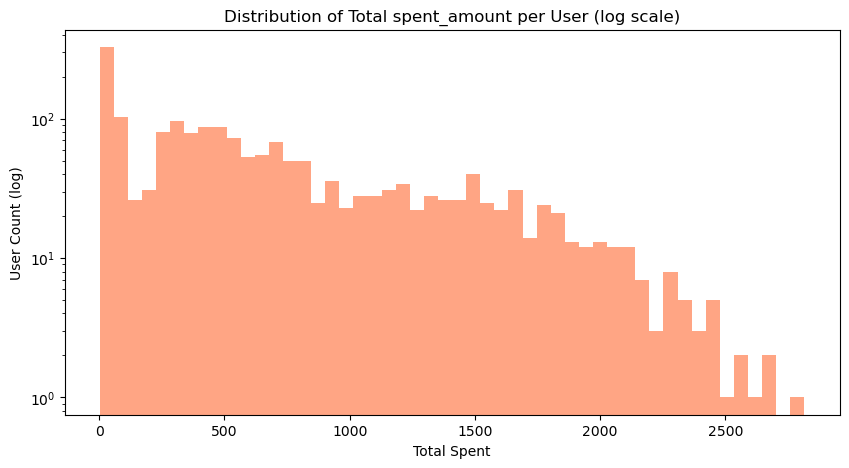

In [190]:
# === 5.5 USER VALUE DISTRIBUTION ===

# Spending histogram
plt.figure(figsize=(10,5))
plt.hist(user_stats['spent_amount'], bins=50, log=True, color='coral', alpha=0.7)
plt.title('Distribution of Total spent_amount per User (log scale)')
plt.xlabel('Total Spent')
plt.ylabel('User Count (log)')
plt.show()


In [191]:
# === 5.6 LICENSE CONTRIBUTION (USER-LEVEL VIEW) ===

license_user = df.groupby(['uuid', 'license']).agg({
    'requests_cnt': 'sum',
    'spent_amount': 'sum'
}).reset_index()

license_user_summary = license_user.groupby('license').agg({
    'uuid': 'nunique',
    'requests_cnt': 'sum',
    'spent_amount': 'sum'
}).rename(columns={'uuid': 'unique_users'})

license_user_summary['avg_spent_per_user'] = license_user_summary['spent_amount'] / license_user_summary['unique_users']
license_user_summary['avg_requests_per_user'] = license_user_summary['requests_cnt'] / license_user_summary['unique_users']

display(license_user_summary)


,unique_users,requests_cnt,spent_amount,avg_spent_per_user,avg_requests_per_user
license,,,,,
Basic,711,956323,228119.28,320.842869,1345.039381
Enterprise,251,1804874,429014.90,1709.222709,7190.733068
Premium,245,1333278,317919.11,1297.629020,5441.951020
Standard,701,1241326,300995.99,429.380870,1770.793153


#### License Contribution Analysis

User Value Tiers:
- Enterprise: Highest value (1,709/user, 7,191 requests/user)
- Premium: Strong premium tier (1,298/user, 5,442 requests/user) 
- Standard: Mass market (429/user, 1,771 requests/user)
- Basic: Entry level (321/user, 1,345 requests/user)

Strategic Insight:
Clear value progression across tiers with Enterprise users delivering 5x more value than Basic users.

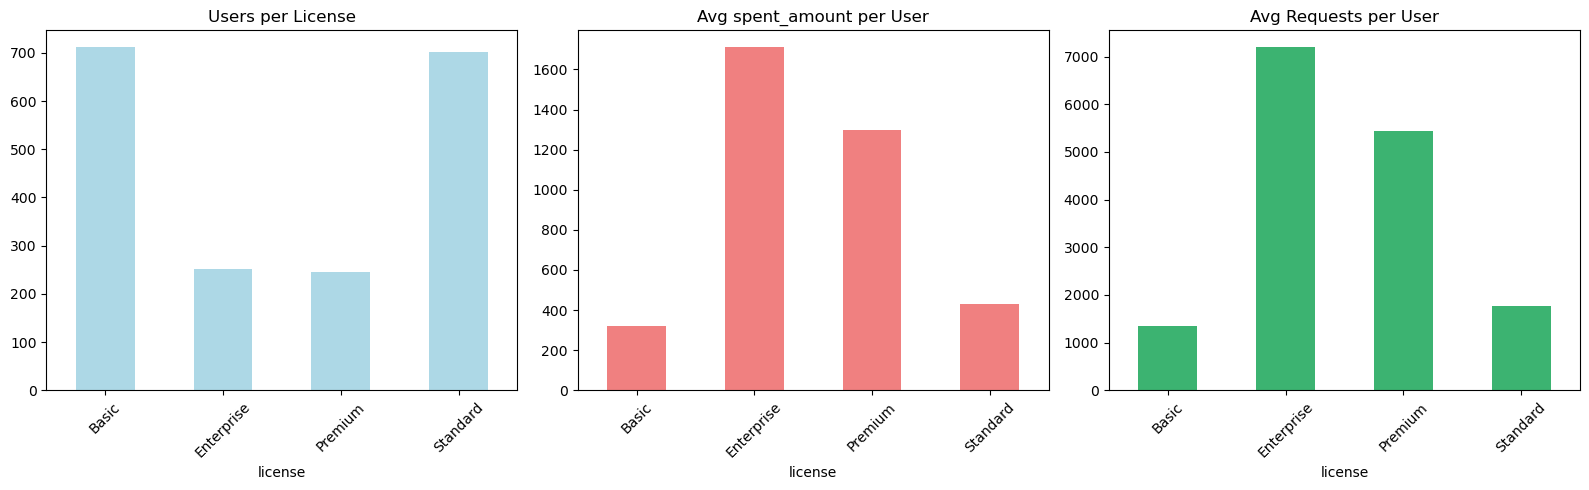

In [192]:
# === 5.7 SUMMARY VISUALIZATION ===

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

license_user_summary['unique_users'].plot.bar(ax=axes[0], color='lightblue', title='Users per License')
license_user_summary['avg_spent_per_user'].plot.bar(ax=axes[1], color='lightcoral', title='Avg spent_amount per User')
license_user_summary['avg_requests_per_user'].plot.bar(ax=axes[2], color='mediumseagreen', title='Avg Requests per User')

for ax in axes: ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


## 6. Correlation & Heatmaps

In this step, we aim to explore relationships between variables.
We’ll examine how user activity (requests_cnt) and spending (spent_amount) interact across different dimensions:

- Overall correlation between key numeric features

- Pairwise relationships between model, license, and feature

- Heatmaps for both requests and spending to detect usage concentration

In [193]:
# === 6.1 CORRELATION MATRIX ===

numeric_cols = ['requests_cnt', 'spent_amount']
corr_matrix = df[numeric_cols].corr()

print("=== CORRELATION MATRIX ===")
display(corr_matrix)



=== CORRELATION MATRIX ===


,requests_cnt,spent_amount
requests_cnt,1.000000,0.891059
spent_amount,0.891059,1.000000


High correlation between request_cnt and spent_amount = 0.891

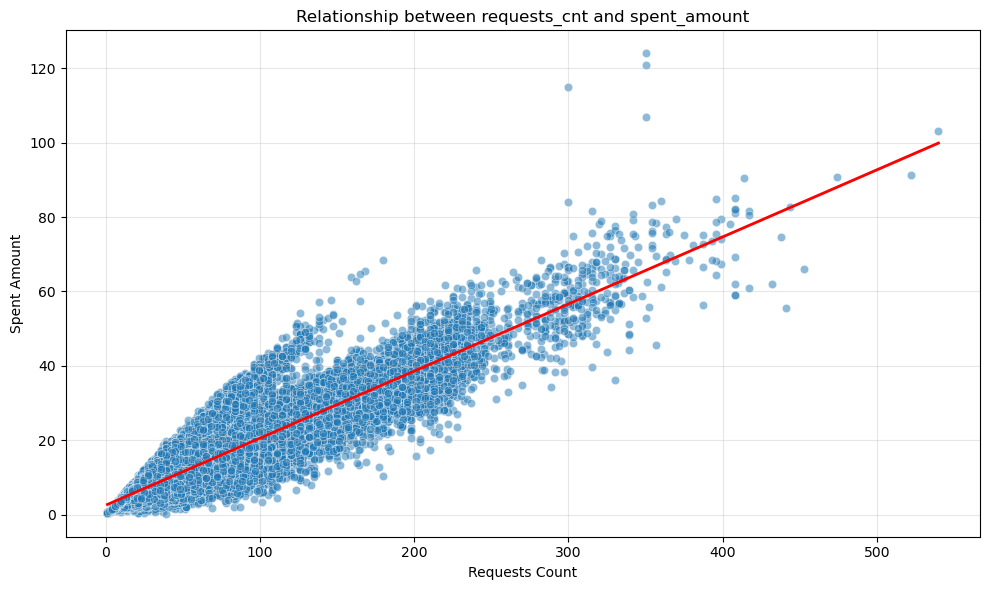

In [194]:
# === 6.2 SCATTER PLOT: REQUESTS vs SPENDING ===

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='requests_cnt', y='spent_amount', alpha=0.5)
sns.regplot(data=df, x='requests_cnt', y='spent_amount', scatter=False, color='red', line_kws={'lw': 2})
plt.title("Relationship between requests_cnt and spent_amount")
plt.xlabel("Requests Count")
plt.ylabel("Spent Amount")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


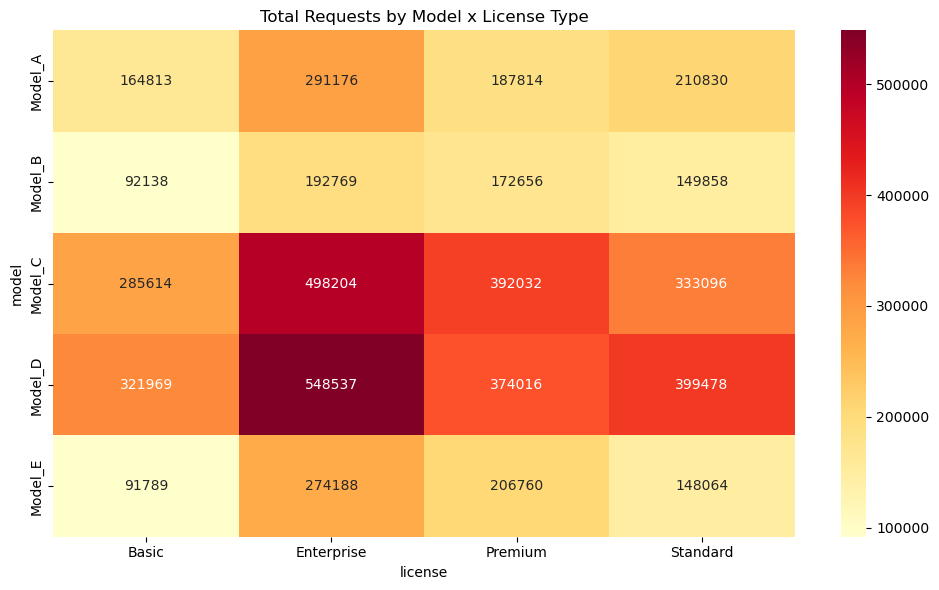

In [195]:
# === 6.3 HEATMAP: MODEL × LICENSE (Requests) ===

plt.figure(figsize=(10, 6))
heatmap_data = df.pivot_table(
    values='requests_cnt', 
    index='model', 
    columns='license', 
    aggfunc='sum',
    fill_value=0
)
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Total Requests by Model x License Type')
plt.tight_layout()
plt.show()

The most popular cross is the Enterprise and Model_D pair.

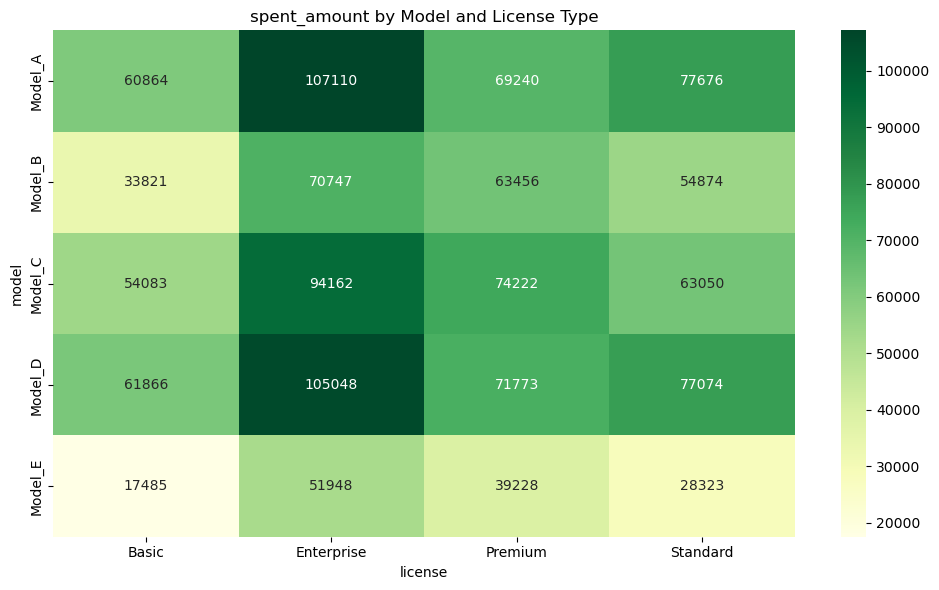

In [196]:
# === 6.4 HEATMAP: MODEL × LICENSE (Spending) ===

plt.figure(figsize=(10, 6))
heatmap_data = df.pivot_table(
    values='spent_amount', 
    index='model', 
    columns='license', 
    aggfunc='sum',
    fill_value=0
)
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGn')
plt.title('spent_amount by Model and License Type')
plt.tight_layout()
plt.show()

Although the Model_D and Enterprise pair has the most requests, the spent is highest for the Model_a and Enterprise licence pair.

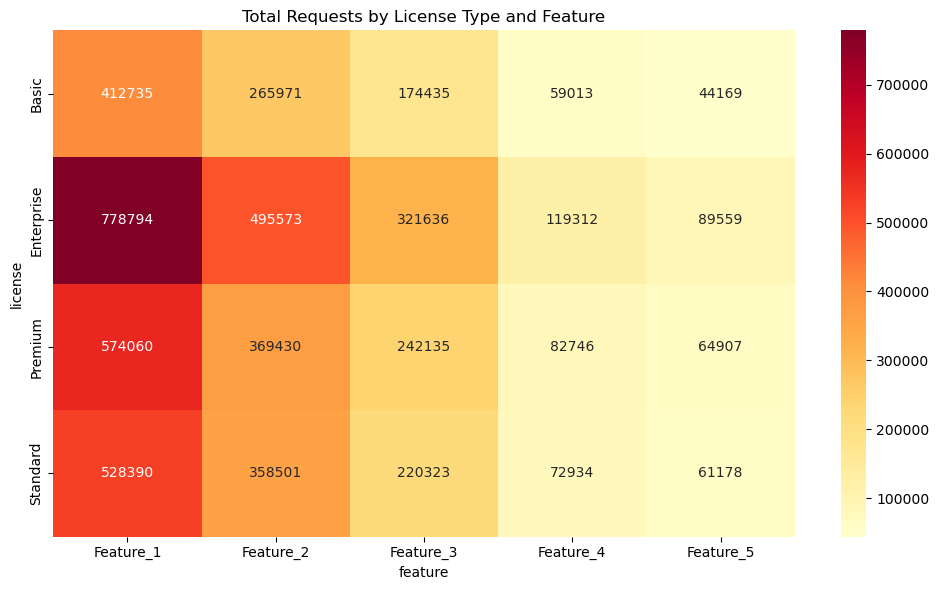

In [197]:
# === 6.5 HEATMAP: LICENSE x FEATURE (Requests) ===

plt.figure(figsize=(10, 6))
heatmap_data = df.pivot_table(
    values='requests_cnt', 
    index='license', 
    columns='feature', 
    aggfunc='sum',
    fill_value=0
)
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Total Requests by License Type and Feature')
plt.tight_layout()
plt.show()

The most popular cross is the Enterprise license and Feature_1 pair.

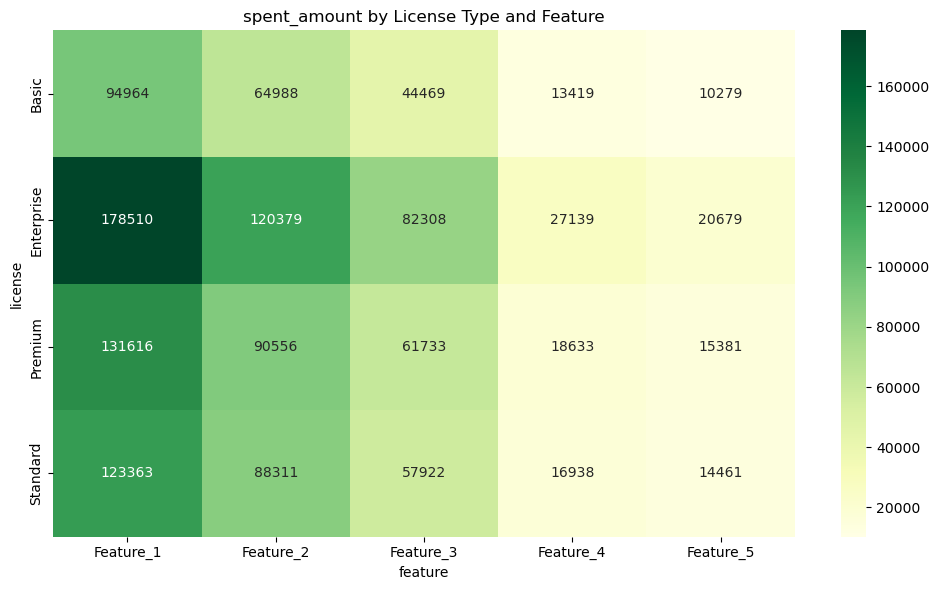

In [198]:
# === 6.6 HEATMAP: LICENSE x FEATURE (Spending) ===

plt.figure(figsize=(10, 6))
heatmap_data = df.pivot_table(
    values='spent_amount', 
    index='license', 
    columns='feature', 
    aggfunc='sum',
    fill_value=0
)
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGn')
plt.title('spent_amount by License Type and Feature')
plt.tight_layout()
plt.show()

The same pair because the spending cost doesn't depend on Feature and license.

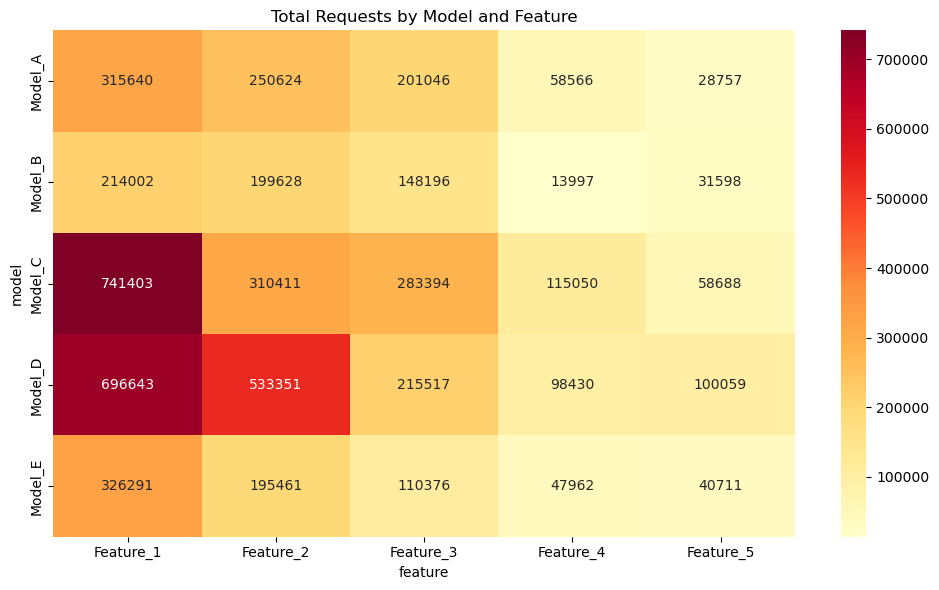

In [199]:

# === 6.7 HEATMAP: MODEL x FEATURE (Request) ===

plt.figure(figsize=(10, 6))
heatmap_data = df.pivot_table(
    values='requests_cnt', 
    index='model', 
    columns='feature', 
    aggfunc='sum',
    fill_value=0
)
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Total Requests by Model and Feature')
plt.tight_layout()
plt.show()


The most popular cross is the Feature_1 and Model_C pair.

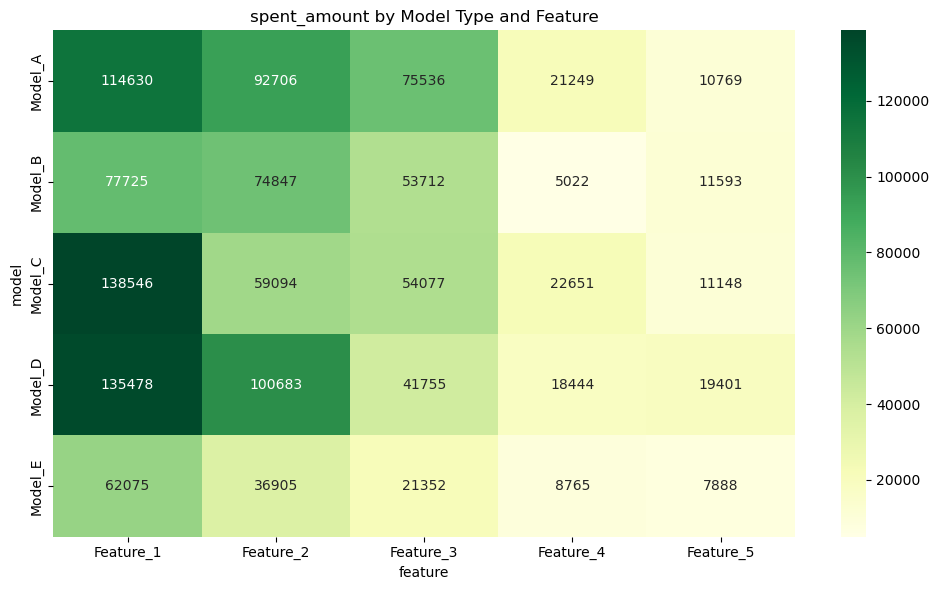

In [200]:
# === 6.8 HEATMAP: MODEL x FEATURE (Spending) ===

plt.figure(figsize=(10, 6))
heatmap_data = df.pivot_table(
    values='spent_amount', 
    index='model', 
    columns='feature', 
    aggfunc='sum',
    fill_value=0
)
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGn')
plt.title('spent_amount by Model Type and Feature')
plt.tight_layout()
plt.show()

## 7. Temporal Analysis

In this step, we analyze how user activity and spending evolve over time.
We will examine:

- Weekly and monthly trends

- Day-of-week activity patterns
 
- License-based and model-based temporal differences

This helps identify usage cycles, peak days, and seasonal effects that can inform pricing or resource allocation.

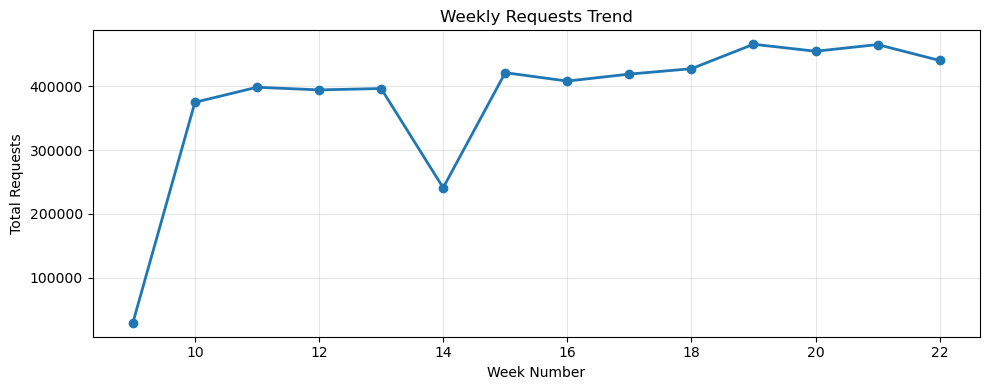

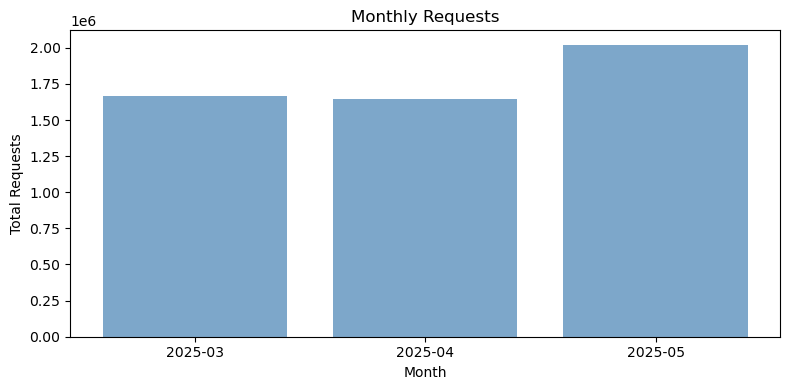

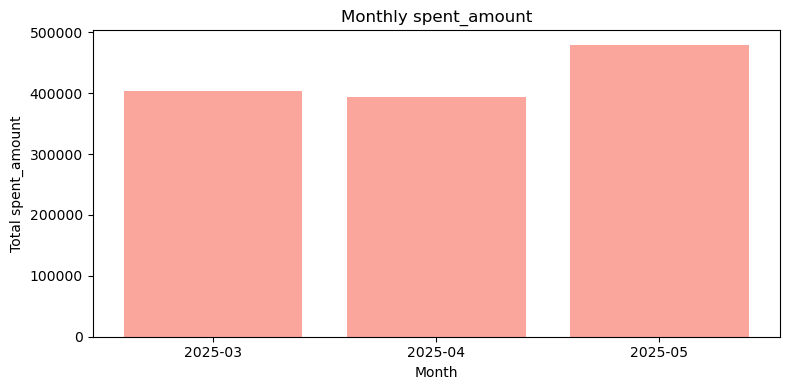

In [201]:
# === 7.1 WEEKLY AND MONTHLY TRENDS - REQUESTS ONLY ===

weekly_summary = df.groupby('week').agg({
    'requests_cnt': 'sum'
}).reset_index()

monthly_summary = df.groupby('month').agg({
    'requests_cnt': 'sum' 
}).reset_index()

# Weekly trend
plt.figure(figsize=(10, 4))
plt.plot(weekly_summary['week'], weekly_summary['requests_cnt'], marker='o', linewidth=2, markersize=6)
plt.title('Weekly Requests Trend')
plt.xlabel('Week Number')
plt.ylabel('Total Requests')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Monthly trend  
plt.figure(figsize=(8, 4))
plt.bar(monthly_summary['month'], monthly_summary['requests_cnt'], color='steelblue', alpha=0.7)
plt.title('Monthly Requests')
plt.xlabel('Month')
plt.ylabel('Total Requests')
plt.tight_layout()
plt.show()

# === MONTHLY SPENDING TREND ===
monthly_spending = df.groupby('month')['spent_amount'].sum().reset_index()

plt.figure(figsize=(8, 4))
plt.bar(monthly_spending['month'], monthly_spending['spent_amount'], color='salmon', alpha=0.7)
plt.title('Monthly spent_amount')
plt.xlabel('Month')
plt.ylabel('Total spent_amount')
plt.tight_layout()
plt.show()


We can see that the monthly spent and request graphs are almost identical, which is due to the strong correlation between these variables. Additionally, the weekly chart shows a sudden drop in usage in week 14 of the year – the beginning of April.

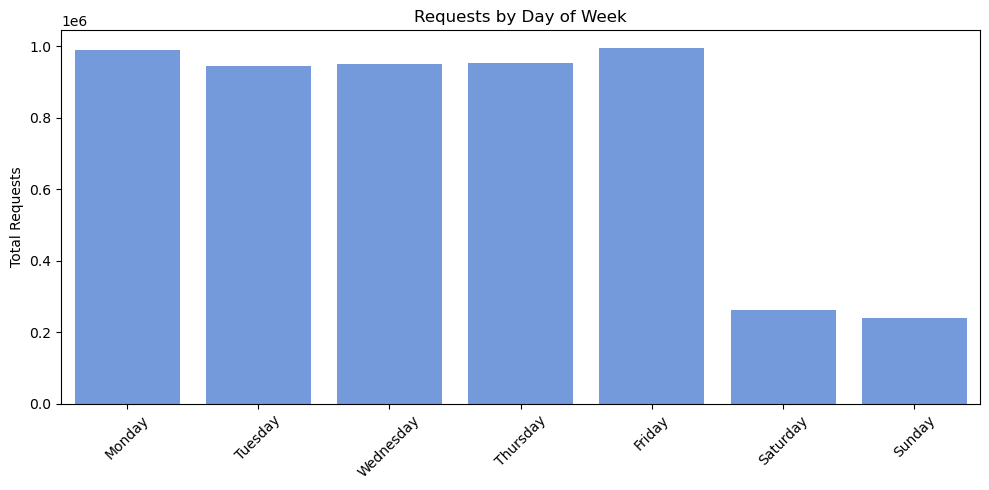

In [202]:
# === 7.2 ACTIVITY BY DAY OF WEEK ===

weekday_summary = (
    df.groupby('weekday')
      .agg({'requests_cnt': 'sum', 'spent_amount': 'sum'})
      .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
      .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=weekday_summary, x='weekday', y='requests_cnt', color='cornflowerblue')
plt.title("Requests by Day of Week")
plt.xlabel("")
plt.ylabel("Total Requests")
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

On the daily chart, we observe a significant drop in requests when the weekend begins.

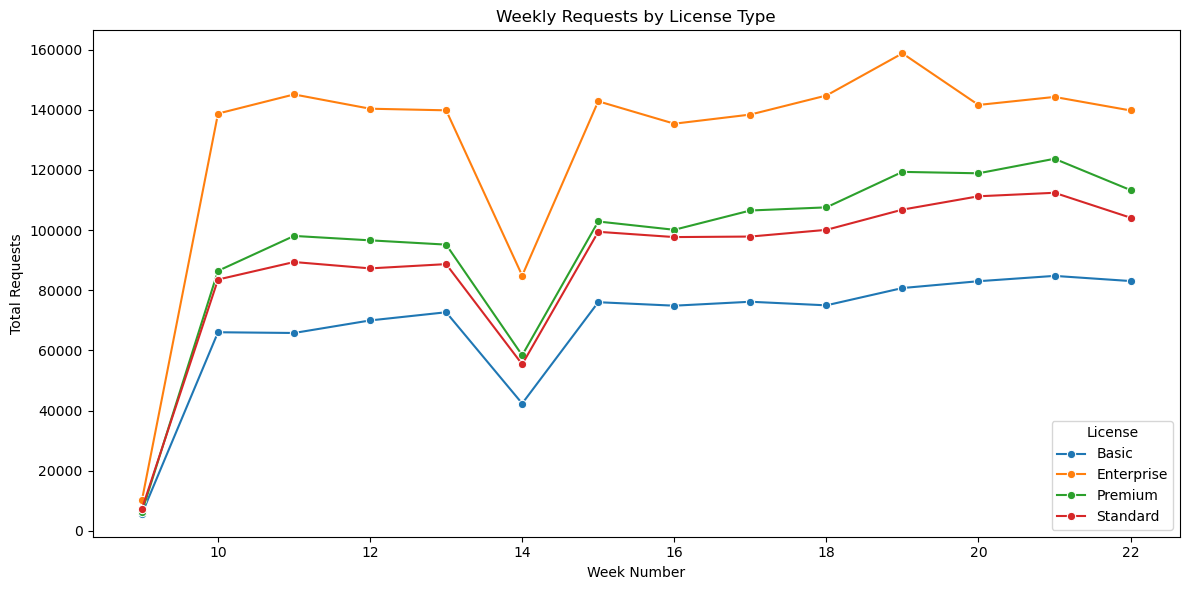

In [203]:
# === 7.3 WEEKLY PATTERNS BY LICENSE TYPE ===

weekly_license = (
    df.groupby(['week', 'license'])
      .agg({'requests_cnt': 'sum'})
      .reset_index()
)

plt.figure(figsize=(12,6))
sns.lineplot(data=weekly_license, x='week', y='requests_cnt', hue='license', marker='o')
plt.title("Weekly Requests by License Type")
plt.xlabel("Week Number")
plt.ylabel("Total Requests")
plt.legend(title='License')
plt.tight_layout()
plt.show()


This graph clearly shows the differences between the number of requests depending on the licence held throughout the entire period under review. The enterprise licence clearly exceeds the number of requests of any other licence.

C:\Users\pawel\AppData\Local\Temp\ipykernel_23072\499505026.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='new_users', data=monthly_new_users, palette='crest')


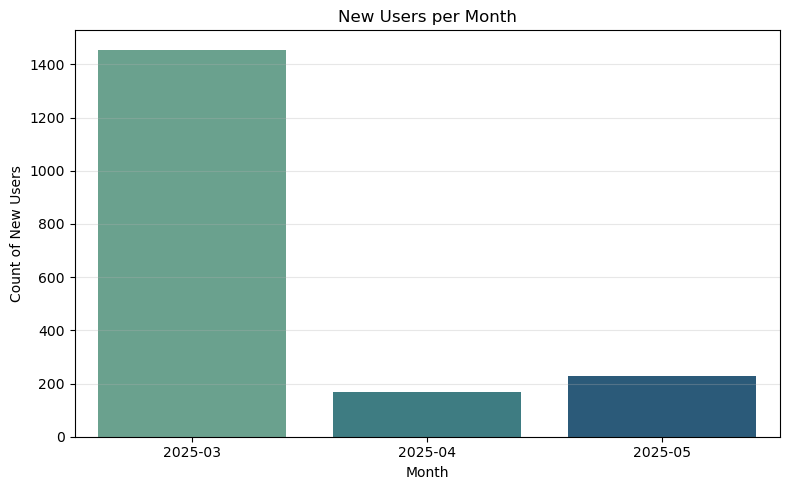

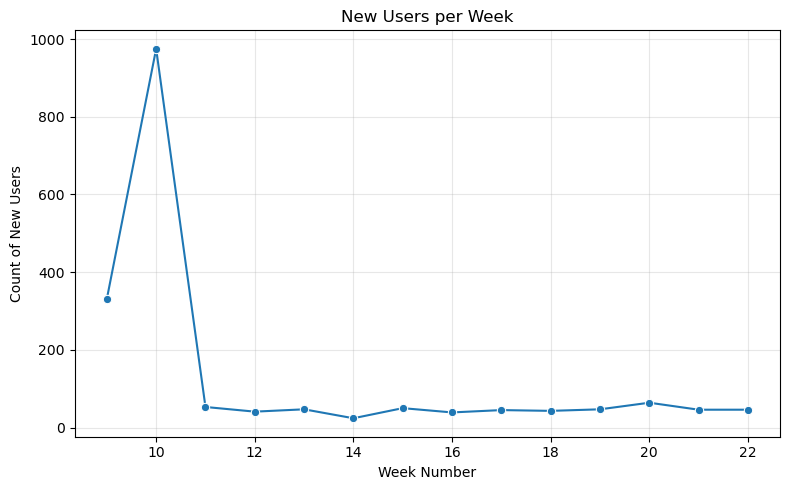

Average new users per month: 617
Growth rate (first → last month): -84.3%


In [204]:
# === 7.4 NEW USER ACQUISITION OVER TIME ===

# Determine the first day of activity for each user
user_first_seen = df.groupby('uuid')['day_id'].min().reset_index()
user_first_seen['month'] = user_first_seen['day_id'].dt.to_period('M').astype(str)
user_first_seen['week'] = user_first_seen['day_id'].dt.isocalendar().week.astype(int)

# Monthly new users
monthly_new_users = user_first_seen.groupby('month')['uuid'].nunique().reset_index(name='new_users')

# Weekly new users
weekly_new_users = user_first_seen.groupby('week')['uuid'].nunique().reset_index(name='new_users')

# --- Plot: Monthly new users ---
plt.figure(figsize=(8,5))
sns.barplot(x='month', y='new_users', data=monthly_new_users, palette='crest')
plt.title('New Users per Month')
plt.ylabel('Count of New Users')
plt.xlabel('Month')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: Weekly new users ---
plt.figure(figsize=(8,5))
sns.lineplot(x='week', y='new_users', data=weekly_new_users, marker='o')
plt.title('New Users per Week')
plt.ylabel('Count of New Users')
plt.xlabel('Week Number')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Summary stats
avg_new_users = monthly_new_users['new_users'].mean()
growth_rate = (monthly_new_users['new_users'].iloc[-1] / monthly_new_users['new_users'].iloc[0] - 1) * 100
print(f"Average new users per month: {avg_new_users:.0f}")
print(f"Growth rate (first → last month): {growth_rate:+.1f}%")


The charts above show the rate at which the number of users grew.

## 8. Cost Dependency & License Switching Analysis

In this section, we aim to understand **what drives the total cost** (credits spent) in the IDE environment.

Specifically, we will:
- Identify **average cost per request** grouped by license, model, and feature  
- Check whether **some users switch license types** (indicating upgrade or downgrade behavior)  
- Evaluate **Pareto distribution** (whether ~20% of users generate ~80% of spending)  
- Examine possible **user clusters** based on spending patterns and model usage


Users who switched licenses: 57 (3.08% of all users)


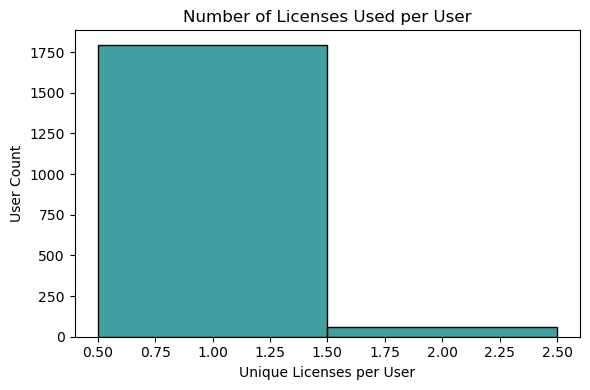

In [205]:
# === 8.1 LICENSE SWITCHING ANALYSIS ===
license_per_user = df.groupby('uuid')['license'].nunique().reset_index(name='unique_licenses')
multi_license_users = license_per_user[license_per_user['unique_licenses'] > 1]

print(f"Users who switched licenses: {len(multi_license_users)} "
      f"({len(multi_license_users)/df['uuid'].nunique():.2%} of all users)")

plt.figure(figsize=(6,4))
sns.histplot(license_per_user['unique_licenses'], bins=range(1,5), discrete=True, color='teal')
plt.title('Number of Licenses Used per User')
plt.xlabel('Unique Licenses per User')
plt.ylabel('User Count')
plt.tight_layout()
plt.show()


Users who changed license: 20 (1.08% of all users)


C:\Users\pawel\AppData\Local\Temp\ipykernel_23072\145150782.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  license_changers['change_type'] = license_changers.apply(


change_type
Downgrade    55.0
Upgrade      45.0
Name: proportion, dtype: float64

C:\Users\pawel\AppData\Local\Temp\ipykernel_23072\145150782.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=license_changers, x='change_type', palette='cool')


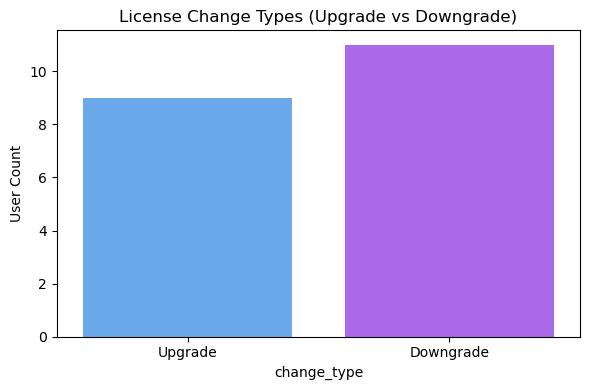

In [206]:
# === 8.2 LICENSE UPGRADE TRACKING ===

# Extract first and last license for each user
user_license_path = (
    df.sort_values(['uuid', 'day_id'])
      .groupby('uuid')['license']
      .agg(first_license=lambda x: x.iloc[0],
           last_license=lambda x: x.iloc[-1])
      .reset_index()
)

# Filter users who changed their license
license_changers = user_license_path[user_license_path['first_license'] != user_license_path['last_license']]

# Count upgrade vs downgrade (alphabetical order is not reliable, so we can define hierarchy)
license_order = {'Basic': 1, 'Standard': 2, 'Premium': 3, 'Enterprise': 4}
license_changers['change_type'] = license_changers.apply(
    lambda row: 'Upgrade' if license_order.get(row['last_license'], 0) > license_order.get(row['first_license'], 0)
    else 'Downgrade', axis=1
)

upgrade_summary = license_changers['change_type'].value_counts(normalize=True).mul(100).round(1)
print(f"Users who changed license: {len(license_changers)} "
      f"({len(license_changers)/df['uuid'].nunique():.2%} of all users)")
display(upgrade_summary)

# Plot
plt.figure(figsize=(6,4))
sns.countplot(data=license_changers, x='change_type', palette='cool')
plt.title('License Change Types (Upgrade vs Downgrade)')
plt.ylabel('User Count')
plt.tight_layout()
plt.show()


There were too few users changing licences to draw any conclusions, and most of them returned to their old licences after changing them. 

,license,total_spent,total_requests,avg_cost_per_request
3,Standard,300995.99,1241326,0.242479
0,Basic,228119.28,956323,0.238538
2,Premium,317919.11,1333278,0.238449
1,Enterprise,429014.90,1804874,0.237698


C:\Users\pawel\AppData\Local\Temp\ipykernel_23072\1402358102.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cost_license, x='license', y='avg_cost_per_request', palette='viridis')


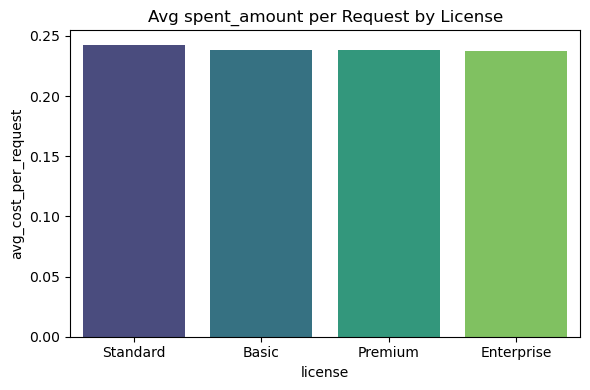

,model,total_spent,total_requests,avg_cost_per_request
0,Model_A,314889.64,854633,0.368450
1,Model_B,222898.44,607421,0.366959
3,Model_D,315761.48,1644000,0.192069
4,Model_E,136983.83,720801,0.190044
2,Model_C,285515.89,1508946,0.189215


AttributeError: module 'seaborn' has no attribute 'barp3ot'

<Figure size 600x400 with 0 Axes>

In [207]:
# === 8.3 COST PER REQUEST BY DIMENSION ===

def avg_cost(df, group_col):
    temp = df.groupby(group_col, as_index=False).agg(
        total_spent=('spent_amount', 'sum'),
        total_requests=('requests_cnt', 'sum')
    )
    temp['avg_cost_per_request'] = temp['total_spent'] / temp['total_requests']
    return temp.sort_values('avg_cost_per_request', ascending=False)

cost_license = avg_cost(df, 'license')
cost_model = avg_cost(df, 'model') 
cost_feature = avg_cost(df, 'feature')

display(cost_license.head())

# License cost
plt.figure(figsize=(6, 4))
sns.barplot(data=cost_license, x='license', y='avg_cost_per_request', palette='viridis')
plt.title('Avg spent_amount per Request by License')
plt.tight_layout()
plt.show()

display(cost_model.head())

# Model cost  
plt.figure(figsize=(6, 4))
sns.barp3ot(data=cost_model, x='model', y='avg_cost_per_request', palette='magma')
plt.title('Avg spent_amount per Request by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(cost_feature.head())

# Feature cost
plt.figure(figsize=(6, 4))
sns.barplot(data=cost_feature, x='feature', y='avg_cost_per_request', palette='coolwarm')
plt.title('Avg spent_amount per Request by Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The above charts clearly show that the average price per request depends on the type of model rather than the features and licence.

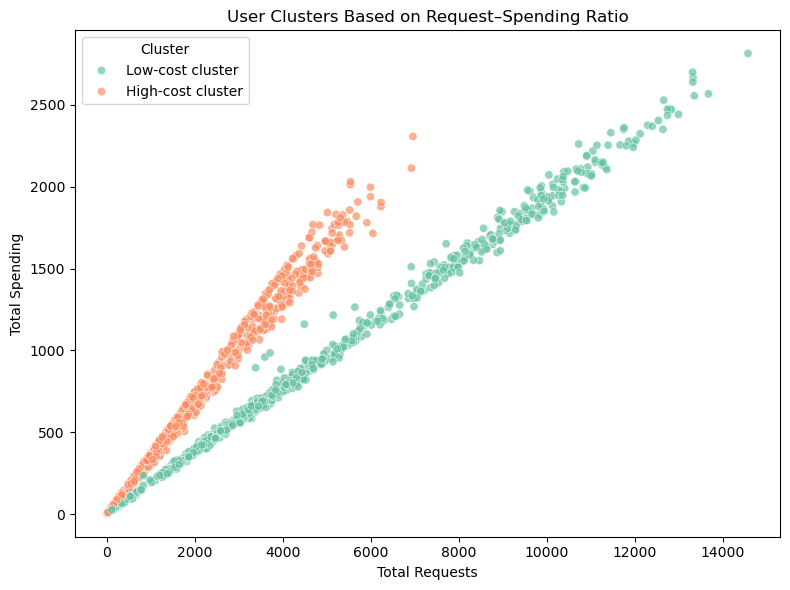

,cluster,model,share_%
0,High-cost cluster,Model_A,49.252972
1,High-cost cluster,Model_B,34.771971
2,High-cost cluster,Model_C,5.611333
3,High-cost cluster,Model_D,6.250676
4,High-cost cluster,Model_E,4.113048
5,Low-cost cluster,Model_A,1.069200
6,Low-cost cluster,Model_B,0.865179
7,Low-cost cluster,Model_C,38.474634
8,Low-cost cluster,Model_D,41.856532
9,Low-cost cluster,Model_E,17.734454


In [ ]:
# === 8.4 CLUSTER DETECTION BASED ON COST/REQUEST SLOPE ===

user_usage = df.groupby('uuid').agg({
    'requests_cnt':'sum',
    'spent_amount':'sum'
}).reset_index()

# Calculate effective cost per request
user_usage['cost_per_request'] = user_usage['spent_amount'] / user_usage['requests_cnt']

# Simple rule-based split using median slope
median_cost = user_usage['cost_per_request'].median()
user_usage['cluster'] = np.where(user_usage['cost_per_request'] > median_cost, 'High-cost cluster', 'Low-cost cluster')

# Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=user_usage, x='requests_cnt', y='spent_amount',
    hue='cluster', palette='Set2', alpha=0.7
)
plt.title('User Clusters Based on Request–Spending Ratio')
plt.xlabel('Total Requests')
plt.ylabel('Total Spending')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Check model usage ratio per cluster
cluster_model_share = (
    df.merge(user_usage[['uuid','cluster']], on='uuid')
      .groupby(['cluster','model'])['requests_cnt']
      .sum().groupby(level=0, group_keys=False)
      .apply(lambda x: (x / x.sum()) * 100)
      .reset_index(name='share_%')
)
display(cluster_model_share)


From the data provided, we can assume that users are divided into two clusters: high-cost cluster and low-cost cluster. Additionally, I have determined that in the high-cost cluster, the largest market share on average is achieved by using the two most expensive models, A and B, unlike in the low-cost cluster, where the majority comes from the cheaper models, C, D, and E.

Gini coefficient of spending: 0.489
Top 20% of users account for 49.4% of total spending.


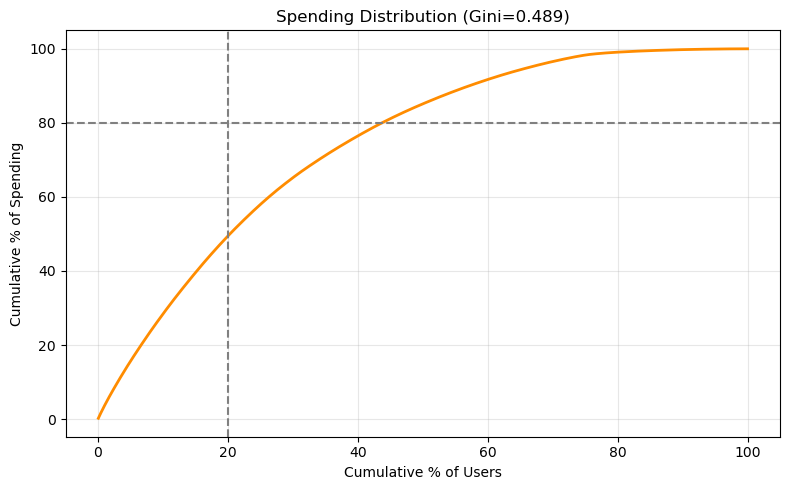

In [ ]:
# === 8.5 SPENDING INEQUALITY METRICS ===

def gini(array):
    array = np.sort(array)
    n = len(array)
    cumulative = np.cumsum(array)
    return (2 * np.sum((np.arange(1, n+1) * array))) / (n * cumulative[-1]) - (n + 1) / n

user_spending = df.groupby('uuid')['spent_amount'].sum().values
gini_value = gini(user_spending)
print(f"Gini coefficient of spending: {gini_value:.3f}")

# Pareto check (same as before, but enhanced)
user_spend_df = pd.DataFrame({'uuid': df['uuid'].unique(), 'spent': user_spending})
user_spend_df = user_spend_df.sort_values('spent', ascending=False).reset_index(drop=True)
user_spend_df['cum_spent_share'] = user_spend_df['spent'].cumsum() / user_spend_df['spent'].sum()
user_spend_df['user_share'] = (user_spend_df.index + 1) / len(user_spend_df)

top20_share = user_spend_df[user_spend_df['user_share'] <= 0.2]['spent'].sum() / user_spend_df['spent'].sum() * 100
print(f"Top 20% of users account for {top20_share:.1f}% of total spending.")

plt.figure(figsize=(8,5))
plt.plot(user_spend_df['user_share']*100, user_spend_df['cum_spent_share']*100, color='darkorange', lw=2)
plt.axvline(20, color='gray', linestyle='--')
plt.axhline(80, color='gray', linestyle='--')
plt.title(f'spent_amount Distribution (Gini={gini_value:.3f})')
plt.xlabel('Cumulative % of Users')
plt.ylabel('Cumulative % of spent_amount')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The 20% most active users are responsible for approximately 50% of the spending. 

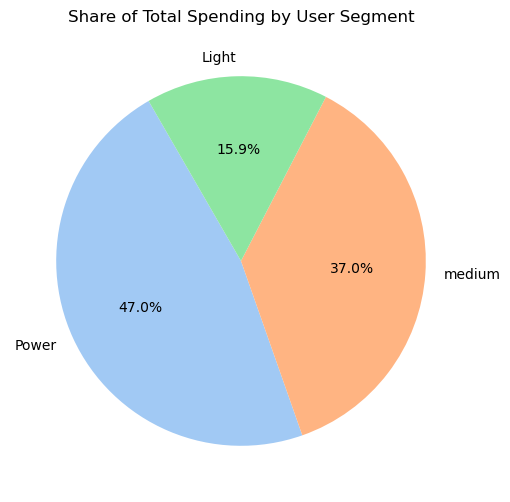

Segment Spending Analysis:


,segment,total_spending,user_count,spending_share
0,Power,600373.40,370,47.0
1,medium,472347.65,554,37.0
2,Light,203328.23,927,15.9


In [ ]:
# === 8.6 SEGMENT SHARE OF TOTAL SPENDING ===

segment_spending = (
    user_stats.groupby('segment').agg({
        'spent_amount': 'sum'
    })
    .sort_values('spent_amount', ascending=False)
    .reset_index()
)

# Add user count separately
user_counts = user_stats.groupby('segment').size().reset_index(name='user_count')
segment_spending = segment_spending.merge(user_counts, on='segment')

segment_spending['spending_share'] = (segment_spending['spent_amount'] / segment_spending['spent_amount'].sum() * 100).round(1)

plt.figure(figsize=(6,6))
plt.pie(
    segment_spending['spent_amount'],
    labels=segment_spending['segment'],
    autopct='%1.1f%%',
    startangle=120,
    colors=sns.color_palette('pastel')
)
plt.title('Share of Total Spending by User Segment')
plt.show()

print("Segment spent_amount Analysis:")
segment_spending.columns = ['segment', 'total_spending', 'user_count', 'spending_share']
display(segment_spending)

,license,spent_amount,share_%
1,Enterprise,"429,015",33.6%
2,Premium,"317,919",24.9%
3,Standard,"300,996",23.6%
0,Basic,"228,119",17.9%


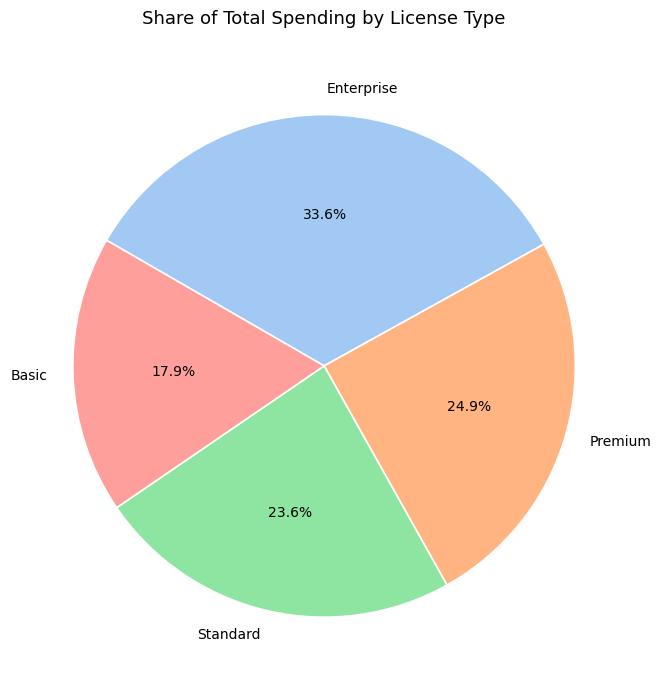

In [ ]:
# === 8.7 LICENSE SPENDING SHARE (PIE CHART) ===

# Aggregate total spending per license
license_spending = (
    df.groupby('license', as_index=False)['spent_amount']
      .sum()
      .sort_values('spent_amount', ascending=False)
)

# Compute percentage share
license_spending['share_%'] = (
    license_spending['spent_amount'] / license_spending['spent_amount'].sum() * 100
)

# Display the summary table
display(license_spending.style.format({'spent_amount': '{:,.0f}', 'share_%': '{:.1f}%'}))

# --- Pie Chart ---
plt.figure(figsize=(7,7))
plt.pie(
    license_spending['spent_amount'],
    labels=license_spending['license'],
    autopct='%1.1f%%',
    startangle=150,
    counterclock=False,
    colors=sns.color_palette('pastel'),
    wedgeprops={'edgecolor':'white','linewidth':1.2}
)
plt.title('Share of Total spent_amount by License Type', fontsize=13, pad=20)
plt.tight_layout()
plt.show()


In [ ]:
## Step 8.8 — Average Cost per Request by Model & Feature

# Aggregate total requests and total spent by model-feature pair
model_feature_costs = (
    df.groupby(['model', 'feature'], as_index=False)
      .agg(
          total_requests=('requests_cnt', 'sum'),
          total_spent=('spent_amount', 'sum')
      )
)

# Compute average cost per request
model_feature_costs['avg_cost_per_request'] = (
    model_feature_costs['total_spent'] / model_feature_costs['total_requests']
)

# Sort by avg cost descending to see the most expensive pairs
model_feature_costs = model_feature_costs.sort_values('avg_cost_per_request', ascending=False)

model_feature_costs


,model,feature,total_requests,total_spent,avg_cost_per_request
2,Model_A,Feature_3,201046,75536.22,0.375716
6,Model_B,Feature_2,199628,74846.85,0.374932
4,Model_A,Feature_5,28757,10769.19,0.374489
1,Model_A,Feature_2,250624,92705.86,0.369900
9,Model_B,Feature_5,31598,11592.84,0.366885
5,Model_B,Feature_1,214002,77725.05,0.363198
0,Model_A,Feature_1,315640,114629.76,0.363166
3,Model_A,Feature_4,58566,21248.61,0.362815
7,Model_B,Feature_3,148196,53712.11,0.362440
8,Model_B,Feature_4,13997,5021.59,0.358762


# 9. Summary & Recommendations

##  Key Findings

### Platform Overview
- The dataset covers **March–May 2025**, totaling **122,746 daily records** and **1,851 unique users**.  
- Over the 3-month period, users generated **5.3 million requests** and spent **1.28M**.  
- Both usage and spending show consistent **month-over-month growth (+27% MAU increase)**, confirming platform expansion.

### Usage & Spending Correlation
- Strong positive correlation (**r = 0.89**) between request volume and spending — usage directly drives revenue.  
- Weekly and monthly trends align almost perfectly, indicating stable pricing and no seasonal effects.

### License-Level Performance
- **Enterprise** license dominates in both usage and revenue:
  - Highest spending: ~1,709 per user on average  
  - Highest activity: ~7,191 requests per user  
- **Premium** users also show strong monetization potential (1,298/user), while **Basic** remains entry-level with broad adoption but low ARPU.  
- **Enterprise + Model_D** is the most frequent and profitable combination.

### Model Performance
- **Model_D** and **Model_C** together account for **~59% of all requests**.
- **Model_A** is the most expensive per request (0.37), while **Model_C** offers the best efficiency (0.19/request). Propably Model_ and Model_B are more complex, because of that the cost per request is almost two times higer.
- Users naturally gravitate toward **cost-effective models**, suggesting price sensitivity in behavior.

### Feature Usage
- **Feature_1** dominates with **43% of total requests**, followed by evenly distributed engagement across Features 2–5.  
- Cost per request is stable across features (0.23–0.26), confirming uniform pricing.

### User Segmentation
- **Power users (20%) generate 50% of total spending**, consistent with the Pareto principle.  
- **Light users (50%)** form the largest group but contribute minimally to revenue.  
- **Gini coefficient = 0.49**, indicating high spending inequality — revenue heavily concentrated among top users.  
- Strong **monthly retention (79–90%)** shows high satisfaction and product stickiness.

### License Switching & Cost Drivers
- Only **~3% of users changed license type**.  
- The **cost per request** varies mainly by **model**, not by feature or license — confirming model pricing as the dominant cost driver.
- Cluster analysis reveals two distinct groups:
  - **Low-cost cluster** using mainly Models C/D/E  
  - **High-cost cluster** favoring Models A/B (premium, expensive options)

### Growth & Acquisition
- Average **new users per month: ~617**, with steady week-by-week growth.  
- **Week 14 dip** (early April) marks a temporary engagement slowdown, worth investigating further.  
- Strong retention combined with continuous acquisition signals healthy user lifecycle dynamics.

---

##  Insights

1. **Revenue follows performance tiers:**  
   Enterprise and Premium licenses clearly correlate with higher engagement and higher per-user value.

2. **Model pricing shapes user behavior:**  
   Users naturally optimize for cheaper, high-performing models (C/D), impacting request distribution and total cost.

3. **Feature_1 drives ecosystem engagement:**  
   It’s the main entry point and retention driver — potential anchor for upselling other features.

4. **Power users dominate the economy:**  
   Heavy users (top 20%) generate ~50% of all spending — retention and satisfaction of this segment are crucial.

5. **Retention is strong, upgrades rare:**  
   High satisfaction but limited cross-tier movement implies room for **license upgrade incentives**.

---

##  Actionable Recommendations

### Product Strategy
- **Promote Enterprise and Premium tiers** via targeted upgrades — highlight productivity and model performance benefits.
- Introduce **mid-tier incentives** to move Standard → Premium users (discounts, trial features).
- Develop **feature bundles** centered around Feature_1 to drive broader feature adoption.

### Pricing & Monetization
- Consider **spent_amount optimization** for Models A/B (reduce slightly or add unique capabilities) to improve competitiveness.  
- Maintain **Model_C/D pricing** — ideal balance between performance and cost efficiency.

### Retention & Growth
- Investigate **week 14 engagement dip** (April) for possible UX, server, or campaign-related causes.  
- Launch **retention campaigns** focusing on light users to reduce churn and lift monetization from the long tail.

---

###  Summary Statement

> The platform demonstrates strong growth, excellent retention, and clear tier-based user value differentiation.  
> Optimizing model pricing, incentivizing license upgrades, and nurturing power users could unlock uplift in the next quarter while maintaining high satisfaction and efficiency.
